# This notebooks aims to make channeling plots

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.interpolate import griddata

import sys
sys.path.append("..")

from channeling_lib import AWS_file_loader, load_path
path = load_path()

## Station information

In [2]:
end_date_now = np.datetime64('2025-01-01')
stations = {'SN99870':{'name':'Adventdalen',
                       'has_wind_data': True, 
                       'wind_direction_data_name':'wind_from_direction',
                       'wind_speed_data_name':'wind_speed',
                       'id':'SN99870',
                       'elevation': 15,
                       'latitude':78.2022,
                       'longitude':15.831,
                        'start_date': np.datetime64('2016-11-21'),
                       'end_date': end_date_now,
                       'valley_orientation':304%180},
            'SN99864':{'name':'Nybyen',
                       'has_wind_data': True, 
                       'wind_direction_data_name':'mean(wind_from_direction PT1M)',
                       'wind_speed_data_name':'mean(wind_speed PT1M)',
                       'id':'SN99864',
                       'elevation': 114,
                       'latitude':78.201609,
                       'longitude':15.59266,
                        'start_date': np.datetime64('2023-11-03'),
                       'end_date': end_date_now,
                       'valley_orientation':30}, # degrees from north
             'SN99858':{'name':'Vannledningsdalen',
                        'has_wind_data': True, 
                       'wind_direction_data_name':'mean(wind_from_direction PT1M)',
                       'wind_speed_data_name':'mean(wind_speed PT1M)',
                       'id':'SN99858',
                       'elevation': 70,
                       'latitude':78.2128,
                       'longitude':15.633,
                        'start_date': np.datetime64('2023-11-03'),
                       'end_date': end_date_now,
                       'valley_orientation':31},
            'SN99840':{'name':'Svalbard Lufthavn',
                       'has_wind_data': True, 
                       'wind_direction_data_name':'wind_from_direction',
                       'wind_speed_data_name':'wind_speed',
                       'id':'SN99840',
                       'elevation': 28,
                       'latitude':78.2453,
                       'longitude':15.5015,
                        #'start_date': np.datetime64('1964-10-16'),
                        'start_date': np.datetime64('1994-12-31'),
                       'end_date': end_date_now,
                       'valley_orientation':305%180}, 
            'SN99843':{'name':'Platåberget III',
                       'has_wind_data': True,
                       'wind_direction_data_name':'wind_from_direction',
                       'wind_speed_data_name':'wind_speed',
                       'id':'SN99843',
                       'elevation': 450,
                       'latitude':78.2278,
                       'longitude':15.378,
                        'start_date': np.datetime64('2018-02-01'),
                       'end_date': end_date_now,
                       'valley_orientation':None}, 
            'SN99857':{'name':'Longyeardalen - Central',
                       'has_wind_data': True,
                       'wind_direction_data_name':'wind_from_direction',
                       'wind_speed_data_name':'wind_speed',
                       'id':'SN99857',
                       'elevation': 52,
                       'latitude':78.2127,
                       'longitude':15.6107,
                        'start_date': np.datetime64('2023-09-16'),
                       'end_date': end_date_now,
                       'valley_orientation':32} }

## Read the data and include it in the dictionary above.

In [3]:
for id_station in tqdm(list(stations.keys())):
    stations[id_station]['wind_speed_data'] = pd.read_csv(path+'SeklimaData/Output/'+id_station+'_'+
                                                          stations[id_station]['wind_speed_data_name']+'.csv',
                                                         parse_dates=['referenceTime'])
    stations[id_station]['wind_direction_data'] = pd.read_csv(path+'SeklimaData/Output/'+id_station+'_'+
                                                          stations[id_station]['wind_direction_data_name']+'.csv',
                                                         parse_dates=['referenceTime'])


100%|███████████████████████████████████████████████████████████| 6/6 [00:25<00:00,  4.22s/it]


## Let's start with Airport VS Platåberget

In [4]:
ws_plataberget = stations['SN99843']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_plataberget'})
ws_airport = stations['SN99840']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_airport'})
wd_plataberget = stations['SN99843']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_plataberget'})
wd_airport = stations['SN99840']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_airport'})

print(ws_plataberget.timeResolution.value_counts(), ws_airport.timeResolution.value_counts())
ws_airport = ws_airport.resample('h').mean(numeric_only=True).dropna(subset=['ws_airport'])
wd_airport = wd_airport.resample('h').mean(numeric_only=True).dropna(subset=['wd_airport'])

airport_plataberget_df = pd.DataFrame(ws_airport.copy()['ws_airport'])

airport_plataberget_df = airport_plataberget_df.merge(wd_airport.wd_airport, left_index=True, right_index=True, how="left")
airport_plataberget_df = airport_plataberget_df.merge(ws_plataberget.ws_plataberget, left_index=True, right_index=True, how="left")
airport_plataberget_df = airport_plataberget_df.merge(wd_plataberget.wd_plataberget, left_index=True, right_index=True, how="left")

airport_plataberget_df.dropna(axis=0, inplace=True)

timeResolution
PT1H    98605
Name: count, dtype: int64 timeResolution
PT10M    282977
PT30M    281731
PT1H     172234
PT6H      25786
Name: count, dtype: int64


Text(0, 0.5, 'Airport (Adventdalen) wind direction (deg from N)')

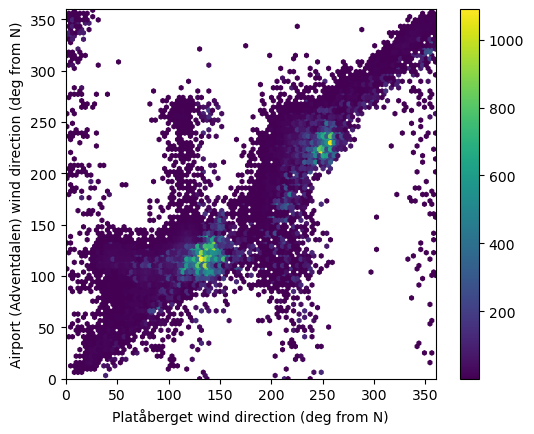

In [5]:
###### ALL WIND SPEEDS
#x = airport_plataberget_df.wd_plataberget
#y = airport_plataberget_df.wd_airport

###### For wind speeds > than some value in m/s
min_speed = 5
condi = airport_plataberget_df.ws_plataberget > min_speed
x = airport_plataberget_df.loc[condi].wd_plataberget
y = airport_plataberget_df.loc[condi].wd_airport

#airport_plataberget_df.plot.scatter(x='wd_plataberget', y='wd_airport')
fig,ax = plt.subplots()
pcm=ax.hexbin(x ,y , mincnt=1)
fig.colorbar(pcm)

ax.set_aspect('equal')
ax.set_xlim(0,360)
ax.set_ylim(0,360)
ax.set_xlabel('Platåberget wind direction (deg from N)')
ax.set_ylabel('Airport (Adventdalen) wind direction (deg from N)')

# Compare for different wind speeds

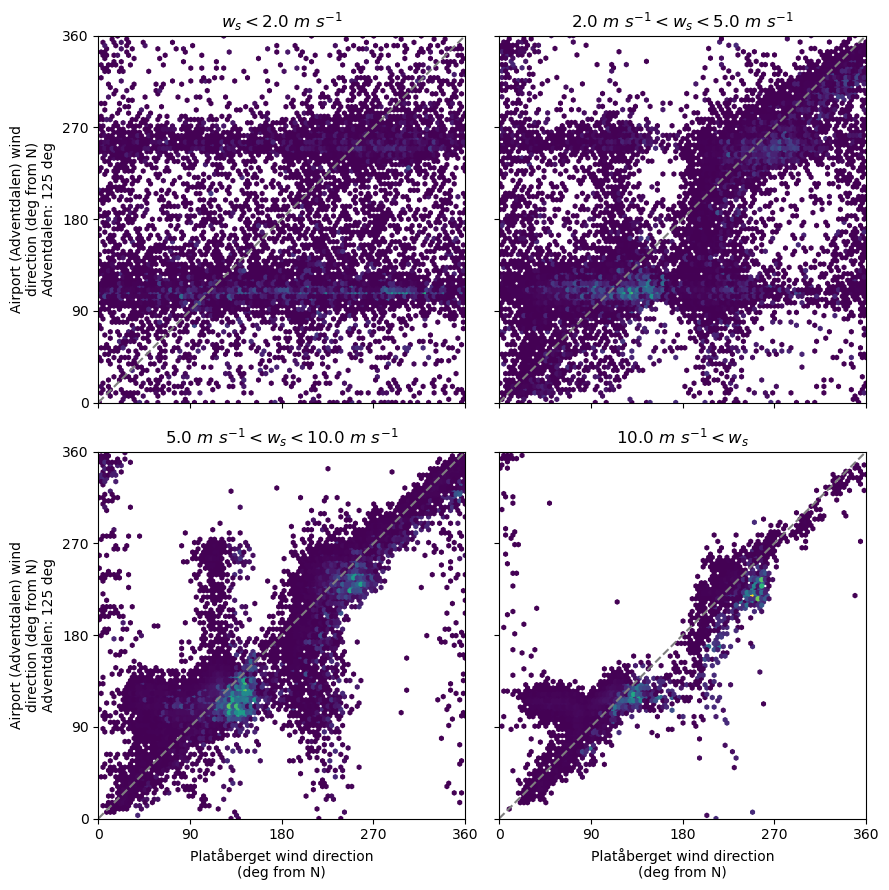

In [6]:
###### For wind speeds > than some value in m/s
wind_speeds = [2,5,10] # length L : L+1 plots
n_plots = len(wind_speeds)+1

if n_plots<3: 
    n_cols=n_plots
    n_rows=1
elif n_plots%2==0: 
    n_cols = 2    
else: 
    n_cols=3
    
n_rows = n_plots//n_cols + n_plots%n_cols


fig,axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*3+3,n_rows*3+3), sharex=True, sharey=True)
axs = axs.ravel()

vmax=1000 # for scaling purposes
vmin=0

condi = airport_plataberget_df.ws_plataberget <= wind_speeds[0]
#condi = airport_plataberget_df.ws_airport <= wind_speeds[0]
x = airport_plataberget_df.loc[condi].wd_plataberget
y = airport_plataberget_df.loc[condi].wd_airport
axs[0].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
axs[0].set_title(r'$w_s < %.1f\ m\ s^{-1}$'%wind_speeds[0])

for i,ws in enumerate(wind_speeds[:-1]):
    condi = np.logical_and(airport_plataberget_df.ws_plataberget > wind_speeds[i],
                           airport_plataberget_df.ws_plataberget < wind_speeds[i+1])
    x = airport_plataberget_df.loc[condi].wd_plataberget
    y = airport_plataberget_df.loc[condi].wd_airport
    axs[i+1].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
    axs[i+1].set_title(r'$%.1f\ m\ s^{-1} < w_s < %.1f\ m\ s^{-1}$'%(wind_speeds[i], wind_speeds[i+1]))
    

condi = airport_plataberget_df.ws_plataberget > wind_speeds[-1]
x = airport_plataberget_df.loc[condi].wd_plataberget
y = airport_plataberget_df.loc[condi].wd_airport
pcm = axs[-1].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
axs[-1].set_title(r'$ %.1f\ m\ s^{-1} < w_s$'%wind_speeds[-1])


for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlim(0,360)
    ax.set_ylim(0,360)
    ax.axline([0,0], slope=1, c='grey', ls='--')
    ax.set_xticks([0,90,180,270,360])
    ax.set_yticks([0,90,180,270,360])
    #ax.grid()

for i in [2,3]: axs[i].set_xlabel('Platåberget wind direction\n(deg from N)')
for i in [0,2]: axs[i].set_ylabel('Airport (Adventdalen) wind\ndirection (deg from N)\nAdventdalen: %i deg'
                 %(stations['SN99840']['valley_orientation']))
#fig.colorbar(pcm, ax=axs, orientation='horizontal', location='top', pad=-.45, shrink=.5, label='counts')

fig.tight_layout()

# Now for Adventdalen

In [7]:
ws_plataberget = stations['SN99843']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_plataberget'})
ws_adventdalen = stations['SN99870']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_adventdalen'})
wd_plataberget = stations['SN99843']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_plataberget'})
wd_adventdalen = stations['SN99870']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_adventdalen'})

print(ws_plataberget.timeResolution.value_counts(), ws_adventdalen.timeResolution.value_counts())
ws_adventdalen = ws_adventdalen.resample('h').mean(numeric_only=True).dropna(subset=['ws_adventdalen'])
wd_adventdalen = wd_adventdalen.resample('h').mean(numeric_only=True).dropna(subset=['wd_adventdalen'])

adventdalen_plataberget_df = pd.DataFrame(ws_adventdalen.copy()['ws_adventdalen'])

adventdalen_plataberget_df = adventdalen_plataberget_df.merge(wd_adventdalen.wd_adventdalen, left_index=True, right_index=True, how="left")
adventdalen_plataberget_df = adventdalen_plataberget_df.merge(ws_plataberget.ws_plataberget, left_index=True, right_index=True, how="left")
adventdalen_plataberget_df = adventdalen_plataberget_df.merge(wd_plataberget.wd_plataberget, left_index=True, right_index=True, how="left")

adventdalen_plataberget_df.dropna(axis=0, inplace=True)

timeResolution
PT1H    98605
Name: count, dtype: int64 timeResolution
PT1H    141234
Name: count, dtype: int64


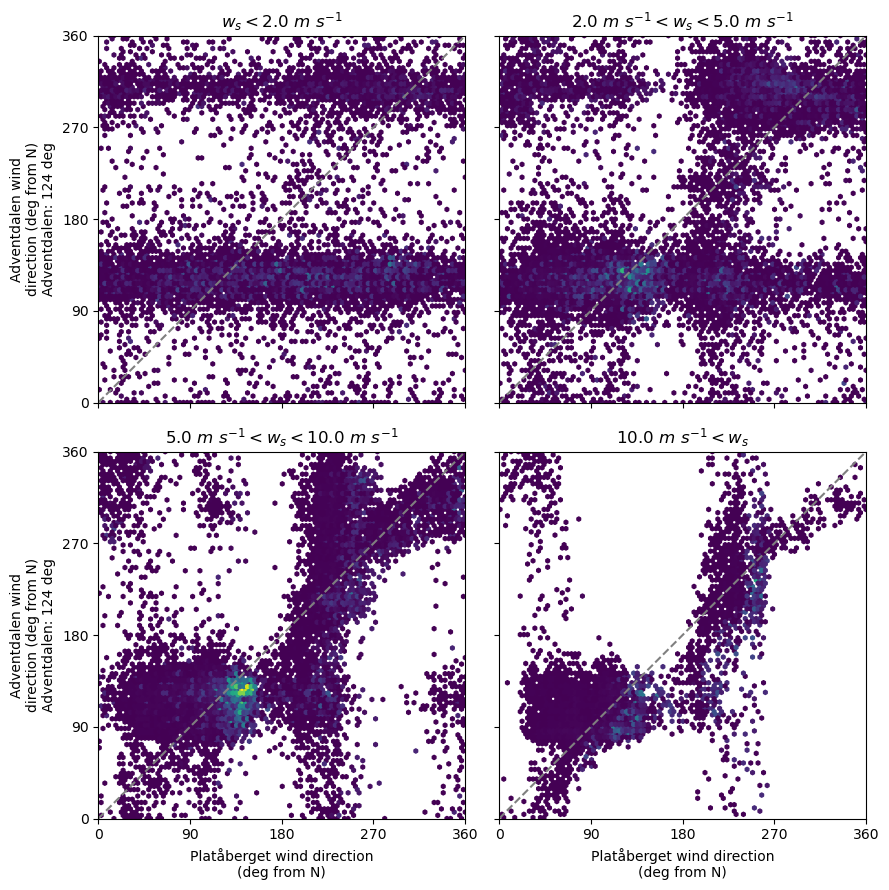

In [8]:
###### For wind speeds > than some value in m/s
#wind_speeds = [2,5,10] # length L : L+1 plots
wind_speeds = [2,5,10] # length L : L+1 plots
n_plots = len(wind_speeds)+1

if n_plots<3: 
    n_cols=n_plots
    n_rows=1
elif n_plots%2==0: 
    n_cols = 2    
else: 
    n_cols=3
    
n_rows = n_plots//n_cols + n_plots%n_cols


fig,axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*3+3,n_rows*3+3), sharex=True, sharey=True)
axs = axs.ravel()

vmax=1000 # for scaling purposes
vmin=0

condi = adventdalen_plataberget_df.ws_plataberget <= wind_speeds[0]
x = adventdalen_plataberget_df.loc[condi].wd_plataberget
y = adventdalen_plataberget_df.loc[condi].wd_adventdalen
axs[0].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
axs[0].set_title(r'$w_s < %.1f\ m\ s^{-1}$'%wind_speeds[0])

for i,ws in enumerate(wind_speeds[:-1]):
    condi = np.logical_and(adventdalen_plataberget_df.ws_plataberget > wind_speeds[i],
                           adventdalen_plataberget_df.ws_plataberget < wind_speeds[i+1])
    x = adventdalen_plataberget_df.loc[condi].wd_plataberget
    y = adventdalen_plataberget_df.loc[condi].wd_adventdalen
    axs[i+1].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
    axs[i+1].set_title(r'$%.1f\ m\ s^{-1} < w_s < %.1f\ m\ s^{-1}$'%(wind_speeds[i], wind_speeds[i+1]))
    

condi = adventdalen_plataberget_df.ws_plataberget > wind_speeds[-1]
x = adventdalen_plataberget_df.loc[condi].wd_plataberget
y = adventdalen_plataberget_df.loc[condi].wd_adventdalen
pcm = axs[-1].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
axs[-1].set_title(r'$ %.1f\ m\ s^{-1} < w_s$'%wind_speeds[-1])


for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlim(0,360)
    ax.set_ylim(0,360)
    ax.axline([0,0], slope=1, c='grey', ls='--')
    ax.set_xticks([0,90,180,270,360])
    ax.set_yticks([0,90,180,270,360])
    #ax.grid()

for i in [2,3]: axs[i].set_xlabel('Platåberget wind direction\n(deg from N)')
for i in [0,2]: axs[i].set_ylabel('Adventdalen wind\ndirection (deg from N)\nAdventdalen: %i deg'
                 %(stations['SN99870']['valley_orientation']))
#fig.colorbar(pcm, ax=axs, orientation='horizontal', location='top', pad=-.45, shrink=.5, label='counts')

fig.tight_layout()

# Now for Longyeardalen - central

In [9]:
ws_plataberget = stations['SN99843']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_plataberget'})
ws_longyeardalen = stations['SN99857']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_longyeardalen'})
wd_plataberget = stations['SN99843']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_plataberget'})
wd_longyeardalen = stations['SN99857']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_longyeardalen'})
#SN99864   SN99858 SN99857
#print(ws_plataberget.timeResolution.value_counts(), ws_nybyen.timeResolution.value_counts())
ws_longyeardalen = ws_longyeardalen.resample('h').mean(numeric_only=True).dropna(subset=['ws_longyeardalen'])
wd_longyeardalen = wd_longyeardalen.resample('h').mean(numeric_only=True).dropna(subset=['wd_longyeardalen'])

longyeardalen_plataberget_df = pd.DataFrame(ws_longyeardalen.copy()['ws_longyeardalen'])

longyeardalen_plataberget_df = longyeardalen_plataberget_df.merge(wd_longyeardalen.wd_longyeardalen, left_index=True, right_index=True, how="left")
longyeardalen_plataberget_df = longyeardalen_plataberget_df.merge(ws_plataberget.ws_plataberget, left_index=True, right_index=True, how="left")
longyeardalen_plataberget_df = longyeardalen_plataberget_df.merge(wd_plataberget.wd_plataberget, left_index=True, right_index=True, how="left")

longyeardalen_plataberget_df.dropna(axis=0, inplace=True)

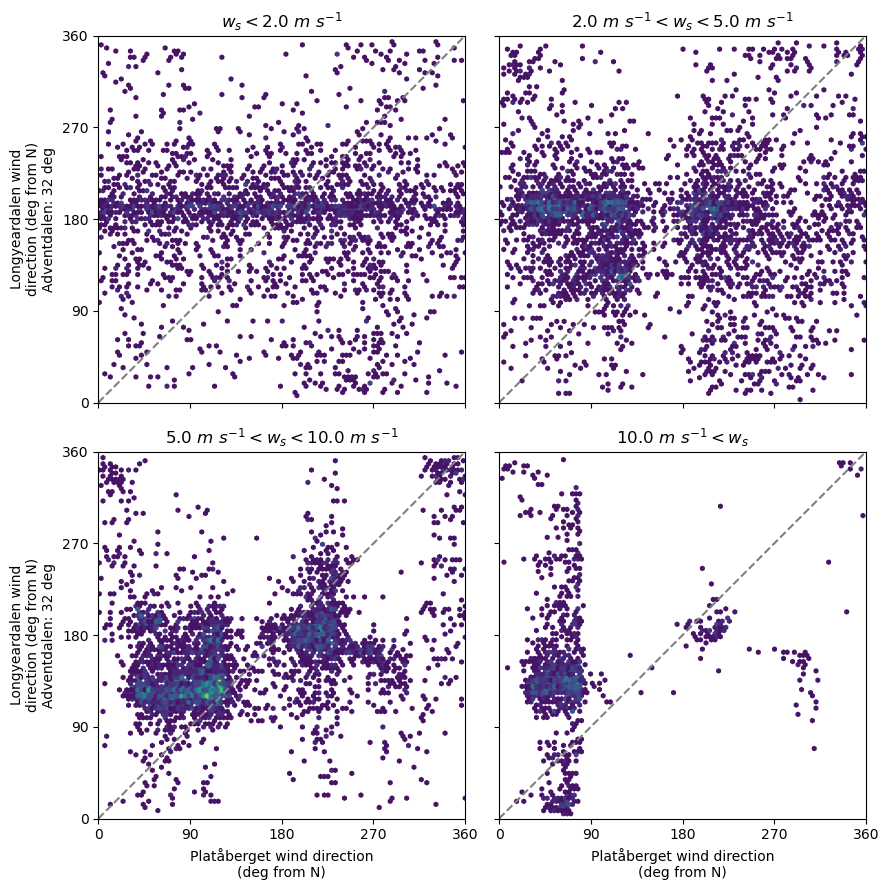

In [10]:
###### For wind speeds > than some value in m/s
#wind_speeds = [2,5,10] # length L : L+1 plots
wind_speeds = [2,5,10] # length L : L+1 plots
n_plots = len(wind_speeds)+1

if n_plots<3: 
    n_cols=n_plots
    n_rows=1
elif n_plots%2==0: 
    n_cols = 2    
else: 
    n_cols=3
    
n_rows = n_plots//n_cols + n_plots%n_cols


fig,axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*3+3,n_rows*3+3), sharex=True, sharey=True)
axs = axs.ravel()

vmax=20 # for scaling purposes
vmin=0

condi = longyeardalen_plataberget_df.ws_plataberget <= wind_speeds[0]
x = longyeardalen_plataberget_df.loc[condi].wd_plataberget
y = longyeardalen_plataberget_df.loc[condi].wd_longyeardalen
axs[0].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
axs[0].set_title(r'$w_s < %.1f\ m\ s^{-1}$'%wind_speeds[0])

for i,ws in enumerate(wind_speeds[:-1]):
    condi = np.logical_and(longyeardalen_plataberget_df.ws_plataberget > wind_speeds[i],
                           longyeardalen_plataberget_df.ws_plataberget < wind_speeds[i+1])
    x = longyeardalen_plataberget_df.loc[condi].wd_plataberget
    y = longyeardalen_plataberget_df.loc[condi].wd_longyeardalen
    axs[i+1].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
    axs[i+1].set_title(r'$%.1f\ m\ s^{-1} < w_s < %.1f\ m\ s^{-1}$'%(wind_speeds[i], wind_speeds[i+1]))
    

condi = longyeardalen_plataberget_df.ws_plataberget > wind_speeds[-1]
x = longyeardalen_plataberget_df.loc[condi].wd_plataberget
y = longyeardalen_plataberget_df.loc[condi].wd_longyeardalen
pcm = axs[-1].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
axs[-1].set_title(r'$ %.1f\ m\ s^{-1} < w_s$'%wind_speeds[-1])


for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlim(0,360)
    ax.set_ylim(0,360)
    ax.axline([0,0], slope=1, c='grey', ls='--')
    ax.set_xticks([0,90,180,270,360])
    ax.set_yticks([0,90,180,270,360])
    #ax.grid()

for i in [2,3]: axs[i].set_xlabel('Platåberget wind direction\n(deg from N)')
for i in [0,2]: axs[i].set_ylabel('Longyeardalen wind\ndirection (deg from N)\nAdventdalen: %i deg'
                 %(stations['SN99857']['valley_orientation']))
#fig.colorbar(pcm, ax=axs, orientation='horizontal', location='top', pad=-.45, shrink=.5, label='counts')

fig.tight_layout()

# Now compare Longyeardalen and Adventdalen

In [11]:
ws_longyeardalen = stations['SN99857']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_longyeardalen'})
ws_adventdalen = stations['SN99870']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_adventdalen'})
wd_longyeardalen = stations['SN99857']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_longyeardalen'})
wd_adventdalen = stations['SN99870']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_adventdalen'})

print(ws_plataberget.timeResolution.value_counts(), ws_adventdalen.timeResolution.value_counts())
ws_adventdalen = ws_adventdalen.resample('h').mean(numeric_only=True).dropna(subset=['ws_adventdalen'])
wd_adventdalen = wd_adventdalen.resample('h').mean(numeric_only=True).dropna(subset=['wd_adventdalen'])
ws_longyeardalen = ws_longyeardalen.resample('h').mean(numeric_only=True).dropna(subset=['ws_longyeardalen'])
wd_longyeardalen = wd_longyeardalen.resample('h').mean(numeric_only=True).dropna(subset=['wd_longyeardalen'])

adventdalen_longyeardalen_df = pd.DataFrame(ws_adventdalen.copy()['ws_adventdalen'])

adventdalen_longyeardalen_df = adventdalen_longyeardalen_df.merge(wd_adventdalen.wd_adventdalen, left_index=True, right_index=True, how="left")
adventdalen_longyeardalen_df = adventdalen_longyeardalen_df.merge(ws_longyeardalen.ws_longyeardalen, left_index=True, right_index=True, how="left")
adventdalen_longyeardalen_df = adventdalen_longyeardalen_df.merge(wd_longyeardalen.wd_longyeardalen, left_index=True, right_index=True, how="left")

adventdalen_longyeardalen_df.dropna(axis=0, inplace=True)

timeResolution
PT1H    98605
Name: count, dtype: int64 timeResolution
PT1H    141234
Name: count, dtype: int64


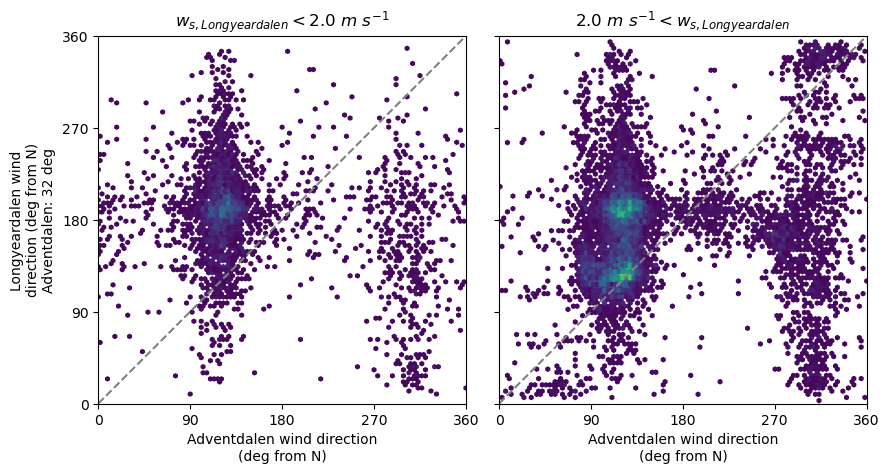

In [12]:
###### For wind speeds > than some value in m/s
wind_speeds = [2] # length L : L+1 plots
#wind_speeds = [2,5,10] # length L : L+1 plots
n_plots = len(wind_speeds)+1

if n_plots<3: 
    n_cols=max(1,n_plots)
    n_rows=1
elif n_plots%2==0: 
    n_cols = 2    
else: 
    n_cols=3
    
n_rows = n_plots//n_cols + n_plots%n_cols


fig,axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*3+3,n_rows*3+3), sharex=True, sharey=True)
if n_plots>1: axs = axs.ravel()

vmax=50 # for scaling purposes
vmin=0

condi = adventdalen_longyeardalen_df.ws_longyeardalen <= wind_speeds[0]
x = adventdalen_longyeardalen_df.loc[condi].wd_adventdalen
y = adventdalen_longyeardalen_df.loc[condi].wd_longyeardalen
axs[0].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
axs[0].set_title(r'$w_{s, Longyeardalen} < %.1f\ m\ s^{-1}$'%wind_speeds[0])

for i,ws in enumerate(wind_speeds[:-1]):
    condi = np.logical_and(adventdalen_longyeardalen_df.ws_adventdalen > wind_speeds[i],
                           adventdalen_longyeardalen_df.ws_adventdalen < wind_speeds[i+1])
    x = adventdalen_longyeardalen_df.loc[condi].wd_adventdalen
    y = adventdalen_longyeardalen_df.loc[condi].wd_longyeardalen
    axs[i+1].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
    axs[i+1].set_title(r'$%.1f\ m\ s^{-1} < w_{s, Longyeardalen} < %.1f\ m\ s^{-1}$'%(wind_speeds[i], wind_speeds[i+1]))
    

condi = adventdalen_longyeardalen_df.ws_adventdalen > wind_speeds[-1]
x = adventdalen_longyeardalen_df.loc[condi].wd_adventdalen
y = adventdalen_longyeardalen_df.loc[condi].wd_longyeardalen
pcm = axs[-1].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
axs[-1].set_title(r'$ %.1f\ m\ s^{-1} < w_{s, Longyeardalen}$'%wind_speeds[-1])


for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlim(0,360)
    ax.set_ylim(0,360)
    ax.axline([0,0], slope=1, c='grey', ls='--')
    ax.set_xticks([0,90,180,270,360])
    ax.set_yticks([0,90,180,270,360])
    #ax.grid()

for i in [0,1]: axs[i].set_xlabel('Adventdalen wind direction\n(deg from N)')
for i in [0]: axs[i].set_ylabel('Longyeardalen wind\ndirection (deg from N)\nAdventdalen: %i deg'
                 %(stations['SN99857']['valley_orientation']))
#fig.colorbar(pcm, ax=axs, orientation='horizontal', location='top', pad=-.45, shrink=.5, label='counts')

fig.tight_layout()

## Maybe Nybyen is better?

In [13]:
ws_nybyen = stations['SN99864']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_nybyen'})
ws_adventdalen = stations['SN99870']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_adventdalen'})
wd_nybyen = stations['SN99864']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_nybyen'})
wd_adventdalen = stations['SN99870']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_adventdalen'})

ws_adventdalen = ws_adventdalen.resample('h').mean(numeric_only=True).dropna(subset=['ws_adventdalen'])
wd_adventdalen = wd_adventdalen.resample('h').mean(numeric_only=True).dropna(subset=['wd_adventdalen'])
ws_nybyen = ws_nybyen.resample('h').mean(numeric_only=True).dropna(subset=['ws_nybyen'])
wd_nybyen = wd_nybyen.resample('h').mean(numeric_only=True).dropna(subset=['wd_nybyen'])

adventdalen_nybyen_df = pd.DataFrame(ws_adventdalen.copy()['ws_adventdalen'])

adventdalen_nybyen_df = adventdalen_nybyen_df.merge(wd_adventdalen.wd_adventdalen, left_index=True, right_index=True, how="left")
adventdalen_nybyen_df = adventdalen_nybyen_df.merge(ws_nybyen.ws_nybyen, left_index=True, right_index=True, how="left")
adventdalen_nybyen_df = adventdalen_nybyen_df.merge(wd_nybyen.wd_nybyen, left_index=True, right_index=True, how="left")

adventdalen_nybyen_df.dropna(axis=0, inplace=True)

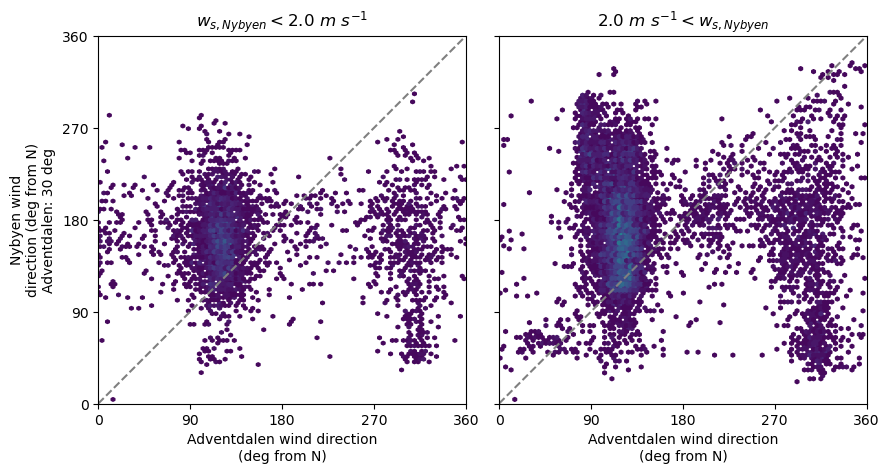

In [14]:
###### For wind speeds > than some value in m/s
wind_speeds = [2] # length L : L+1 plots
#wind_speeds = [2,5,10] # length L : L+1 plots
n_plots = len(wind_speeds)+1

if n_plots<3: 
    n_cols=n_plots
    n_rows=1
elif n_plots%2==0: 
    n_cols = 2    
else: 
    n_cols=3
    
n_rows = n_plots//n_cols + n_plots%n_cols


fig,axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*3+3,n_rows*3+3), sharex=True, sharey=True)
axs = axs.ravel()

vmax=50 # for scaling purposes
vmin=0

condi = adventdalen_nybyen_df.ws_nybyen <= wind_speeds[0]
x = adventdalen_nybyen_df.loc[condi].wd_adventdalen
y = adventdalen_nybyen_df.loc[condi].wd_nybyen
axs[0].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
axs[0].set_title(r'$w_{s, Nybyen} < %.1f\ m\ s^{-1}$'%wind_speeds[0])

for i,ws in enumerate(wind_speeds[:-1]):
    condi = np.logical_and(adventdalen_nybyen_df.ws_adventdalen > wind_speeds[i],
                           adventdalen_nybyen_df.ws_adventdalen < wind_speeds[i+1])
    x = adventdalen_nybyen_df.loc[condi].wd_adventdalen
    y = adventdalen_nybyen_df.loc[condi].wd_nybyen
    axs[i+1].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
    axs[i+1].set_title(r'$%.1f\ m\ s^{-1} < w_{s, Nybyen} < %.1f\ m\ s^{-1}$'%(wind_speeds[i], wind_speeds[i+1]))
    

condi = adventdalen_nybyen_df.ws_adventdalen > wind_speeds[-1]
x = adventdalen_nybyen_df.loc[condi].wd_adventdalen
y = adventdalen_nybyen_df.loc[condi].wd_nybyen
pcm = axs[-1].hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin)
axs[-1].set_title(r'$ %.1f\ m\ s^{-1} < w_{s, Nybyen}$'%wind_speeds[-1])


for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlim(0,360)
    ax.set_ylim(0,360)
    ax.axline([0,0], slope=1, c='grey', ls='--')
    ax.set_xticks([0,90,180,270,360])
    ax.set_yticks([0,90,180,270,360])
    #ax.grid()

for i in [0,1]: axs[i].set_xlabel('Adventdalen wind direction\n(deg from N)')
for i in [0]: axs[i].set_ylabel('Nybyen wind\ndirection (deg from N)\nAdventdalen: %i deg'
                 %(stations['SN99864']['valley_orientation']))
#fig.colorbar(pcm, ax=axs, orientation='horizontal', location='top', pad=-.45, shrink=.5, label='counts')

fig.tight_layout()

# Look at the storm specifically

Using the Platåberget and Rosanna stations, since they are the closest with wind direction data.

<Axes: xlabel='referenceTime'>

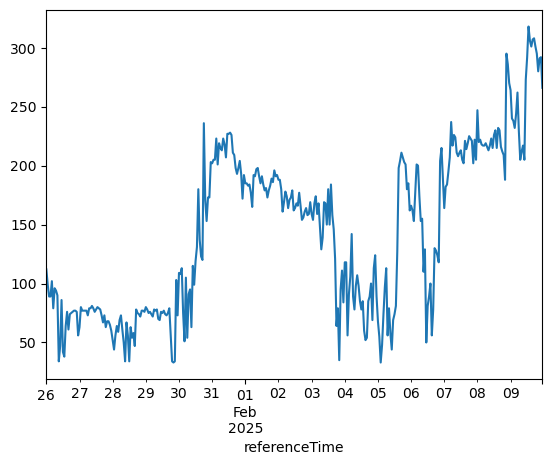

In [15]:
plataberget_AGFperiod_raw = pd.read_csv(load_path()+'SeklimaData/Plataberget_wind_20250126-20250210.csv', parse_dates=['referenceTime'])#, index_col='referenceTime')
plataberget_AGFperiod_raw['referenceTime'] = plataberget_AGFperiod_raw['referenceTime'].dt.tz_localize(None)
plataberget_AGFperiod_raw.set_index('referenceTime', inplace=True)

plataberget_AGFperiod = pd.DataFrame(plataberget_AGFperiod_raw.loc[plataberget_AGFperiod_raw.elementId=='wind_from_direction']['value']
                                    ).rename(columns={'value':'plataberget_wind_from_direction'})
plataberget_AGFperiod['plataberget_wind_speed'] = plataberget_AGFperiod_raw.loc[plataberget_AGFperiod_raw.elementId=='wind_speed']['value']

plataberget_AGFperiod.plataberget_wind_from_direction.plot()

<Axes: xlabel='TIMESTAMP'>

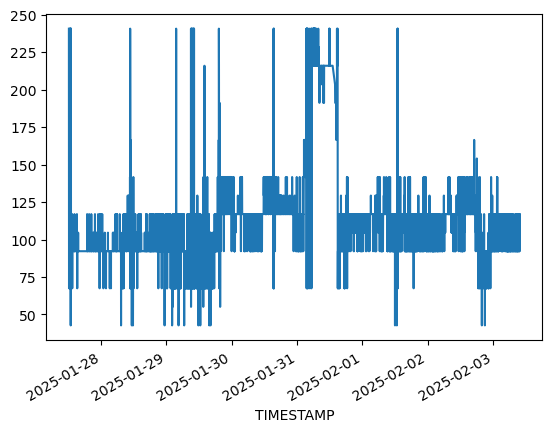

In [16]:
pd.read_csv('/home/clc/Desktop/AGF350_data/Data/CalibratedData/AWS/bettedavis_filtered_data.csv', parse_dates=['TIMESTAMP'], index_col='TIMESTAMP').wind_direction.plot()

In [17]:
fnames = ! ls {load_path()}CalibratedData/AWS/*.csv

channeling_our_obs_plataberget_adventdalen = pd.DataFrame({'wd_AWS':[], 'wd_plataberget':[]})

def mean_wind_direction(wind_directions):
    """When resampling with pandas, you need to specify a method,
    for example: mean. This works great but not for wind direction
    because it has cyclical boundaries. You can use the following
    line of code instead:
    df.resample('h').apply(mean_wind_direction)
    will resample your wind direction at any scale (maybe at minute
    time scale?) to an hourly, with proper mean.
    
    It converts all your wind directions into unit vectors, takes 
    the cos and sin of the sum of all vectors to compute the hourly
    mean.
    """
    wind_directions = np.radians(wind_directions)  # Convert to radians
    u = np.cos(wind_directions)
    v = np.sin(wind_directions)
    
    mean_u = np.mean(u)
    mean_v = np.mean(v)
    
    mean_angle = np.arctan2(mean_v, mean_u)  # Compute mean angle
    mean_angle = np.degrees(mean_angle)  # Convert back to degrees
    return mean_angle % 360  # Ensure it is within 0-360°

for fn in fnames:
    if not fn.split('/')[-1].startswith('bettedavis'):
        df_temp = pd.read_csv(fn, parse_dates=['TIMESTAMP'], index_col='TIMESTAMP')
        df_temp = df_temp.resample('h').apply(mean_wind_direction)
        df_temp = df_temp.merge(plataberget_AGFperiod.plataberget_wind_from_direction, left_index=True, right_index=True, how="left")
        channeling_our_obs_plataberget_adventdalen = pd.concat([channeling_our_obs_plataberget_adventdalen, pd.DataFrame({'wd_AWS':df_temp.wind_direction,
                                                                          'wd_plataberget':df_temp.plataberget_wind_from_direction})], ignore_index=True)
        print(df_temp.index[0], df_temp.index[-1])
        #df_temp = df_temp.merge(
        #plt.hist(pd.read_csv(fn).wind_direction, bins=100)
        #plt.title(fn.split('/')[-1][:-4])
        #plt.xlim(0,360)
        #plt.show()

#channeling_our_obs

2025-01-26 11:00:00 2025-02-03 11:00:00
2025-01-27 14:00:00 2025-02-03 10:00:00
2025-01-27 10:00:00 2025-02-03 09:00:00
2025-01-26 14:00:00 2025-02-03 12:00:00


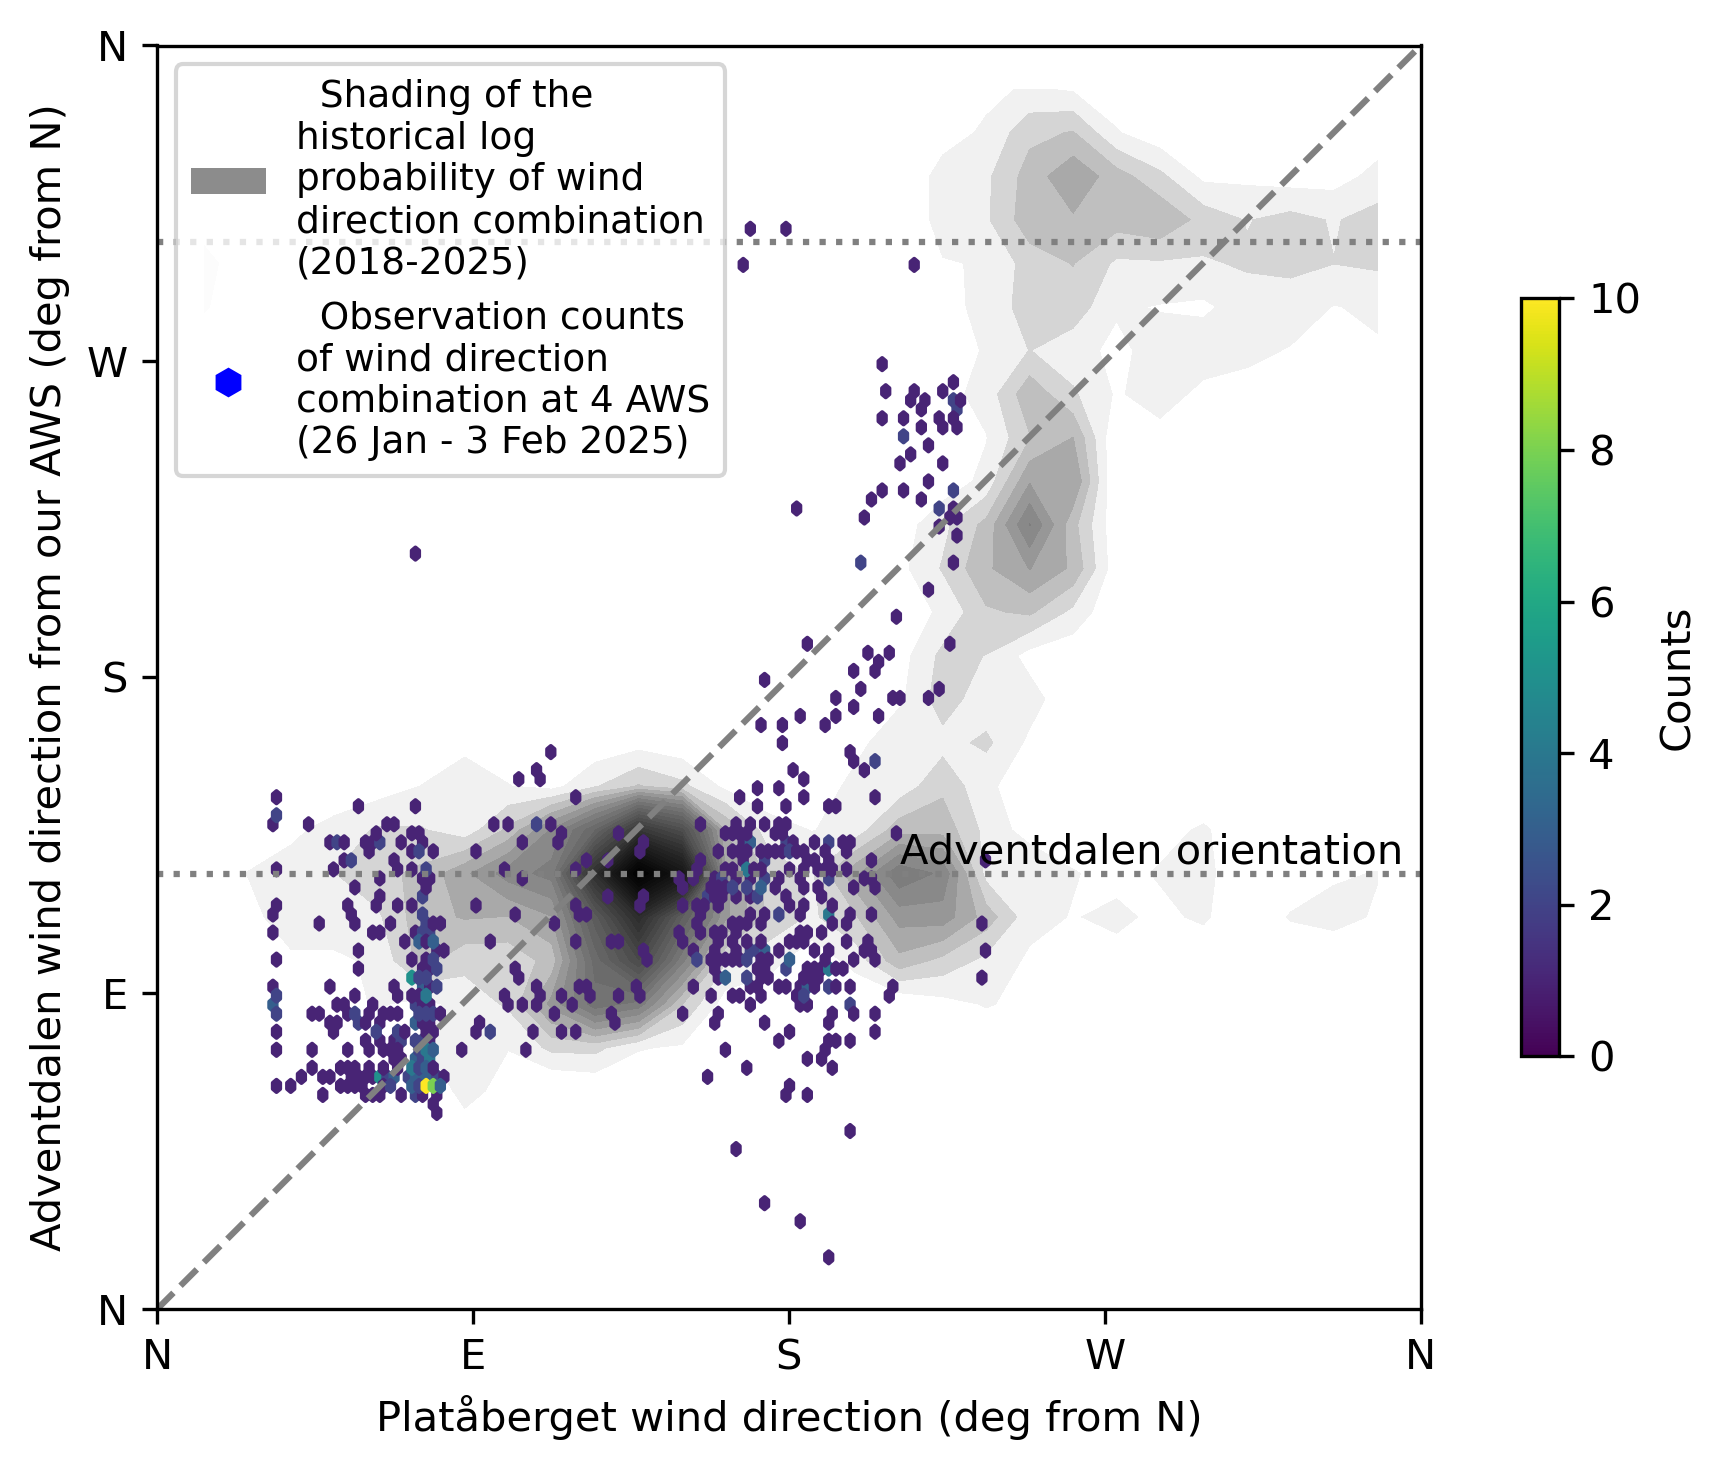

In [18]:
###### For wind speeds > than some value in m/s
#wind_speeds = [2,5,10] # length L : L+1 plots

fig,ax = plt.subplots(figsize=(7,5), dpi=300)

vmax=10 # for scaling purposes
vmin=0
min_ws = 2

condi = adventdalen_plataberget_df.ws_plataberget >= min_ws
x = adventdalen_plataberget_df.loc[condi].wd_plataberget
y = adventdalen_plataberget_df.loc[condi].wd_adventdalen

counts, xedges, yedges = np.histogram2d(x, y, bins=30)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xcenters, ycenters)

# Step 3: Interpolate counts onto a finer grid
xi = np.linspace(x.min(), x.max(), 30)  # Fine grid for contours
yi = np.linspace(y.min(), y.max(), 30)
XI, YI = np.meshgrid(xi, yi)
ZI = griddata((X.ravel(), Y.ravel()), counts.T.ravel(), (XI, YI), method='cubic')

ax.contourf(XI, YI, ZI, levels=30, cmap="Greys", norm='log')
#ax.hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin, cmap='Greys')
#ax.set_title(r'$w_s < %.1f\ m\ s^{-1}$'%wind_speeds[0])

ax.set_aspect('equal')
ax.set_xlim(0,360)
ax.set_ylim(0,360)
ax.axline([0,0], slope=1, c='grey', ls='--')
ax.set_xticks([0,90,180,270,360], labels=['N','E','S','W','N'])
ax.set_yticks([0,90,180,270,360], labels=['N','E','S','W','N'])
    #ax.grid()

ax.set_xlabel('Platåberget wind direction (deg from N)')
ax.set_ylabel('Adventdalen wind direction from our AWS (deg from N)')
#fig.colorbar(pcm, ax=axs, orientation='horizontal', location='top', pad=-.45, shrink=.5, label='counts')

ax.legend([Patch(facecolor='grey', alpha=.9),
           Line2D([0], [0], lw=0, marker='h', color='blue')],
                  ['  Shading of the\nhistorical log\nprobability of wind\ndirection combination\n(2018-2025)', 
                   '  Observation counts\nof wind direction\ncombination at 4 AWS\n(26 Jan - 3 Feb 2025)'], loc='upper left', fontsize=9)

pcm=ax.hexbin(channeling_our_obs_plataberget_adventdalen.wd_plataberget, channeling_our_obs_plataberget_adventdalen.wd_AWS, mincnt=1, vmax=vmax, vmin=vmin)
fig.colorbar(pcm, shrink=.6, label='Counts')
ax.axhline(stations['SN99870']['valley_orientation'], ls=':', c='grey')
ax.axhline(stations['SN99870']['valley_orientation']+180, ls=':', c='grey')
ax.text(355, stations['SN99870']['valley_orientation']+3, 'Adventdalen orientation', ha='right')
fig.tight_layout()

plt.savefig('../figs/channeling_adventdalen_our_storm_VS_history.png')

## Now Nybyen/Adventdalen during our period of obs

<Axes: xlabel='referenceTime'>

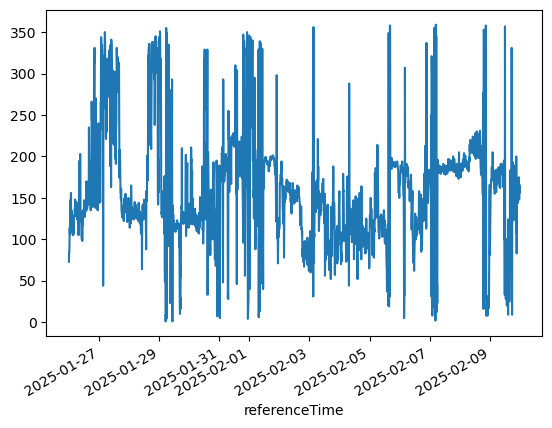

In [19]:
nybyen_AGFperiod_raw = pd.read_csv(load_path()+'SeklimaData/Nybyen_wind_20250126-20250210.csv', parse_dates=['referenceTime'])#, index_col='referenceTime')
nybyen_AGFperiod_raw['referenceTime'] = nybyen_AGFperiod_raw['referenceTime'].dt.tz_localize(None)
nybyen_AGFperiod_raw.set_index('referenceTime', inplace=True)

nybyen_AGFperiod = pd.DataFrame(nybyen_AGFperiod_raw.loc[nybyen_AGFperiod_raw.elementId=='wind_from_direction']['value']
                                    ).rename(columns={'value':'nybyen_wind_from_direction'})
nybyen_AGFperiod['nybyen_wind_speed'] = nybyen_AGFperiod_raw.loc[nybyen_AGFperiod_raw.elementId=='wind_speed']['value']

nybyen_AGFperiod.nybyen_wind_from_direction.plot()

In [20]:
channeling_our_obs_nybyen_adventdalen = pd.DataFrame({'wd_AWS':[], 'wd_nybyen':[]})

for fn in fnames:
    if not fn.split('/')[-1].startswith('bettedavis'):
        df_temp = pd.read_csv(fn, parse_dates=['TIMESTAMP'], index_col='TIMESTAMP')
        df_temp = df_temp.resample('h').apply(mean_wind_direction)
        df_temp = df_temp.merge(nybyen_AGFperiod.nybyen_wind_from_direction, left_index=True, right_index=True, how="left")
        channeling_our_obs_nybyen_adventdalen = pd.concat([channeling_our_obs_nybyen_adventdalen, pd.DataFrame({'wd_AWS':df_temp.wind_direction,
                                                                          'wd_nybyen':df_temp.nybyen_wind_from_direction})], ignore_index=True)
        print(df_temp.index[0], df_temp.index[-1])
        #df_temp = df_temp.merge(
        #plt.hist(pd.read_csv(fn).wind_direction, bins=100)
        #plt.title(fn.split('/')[-1][:-4])
        #plt.xlim(0,360)
        #plt.show()

#channeling_our_obs

2025-01-26 11:00:00 2025-02-03 11:00:00
2025-01-27 14:00:00 2025-02-03 10:00:00
2025-01-27 10:00:00 2025-02-03 09:00:00
2025-01-26 14:00:00 2025-02-03 12:00:00


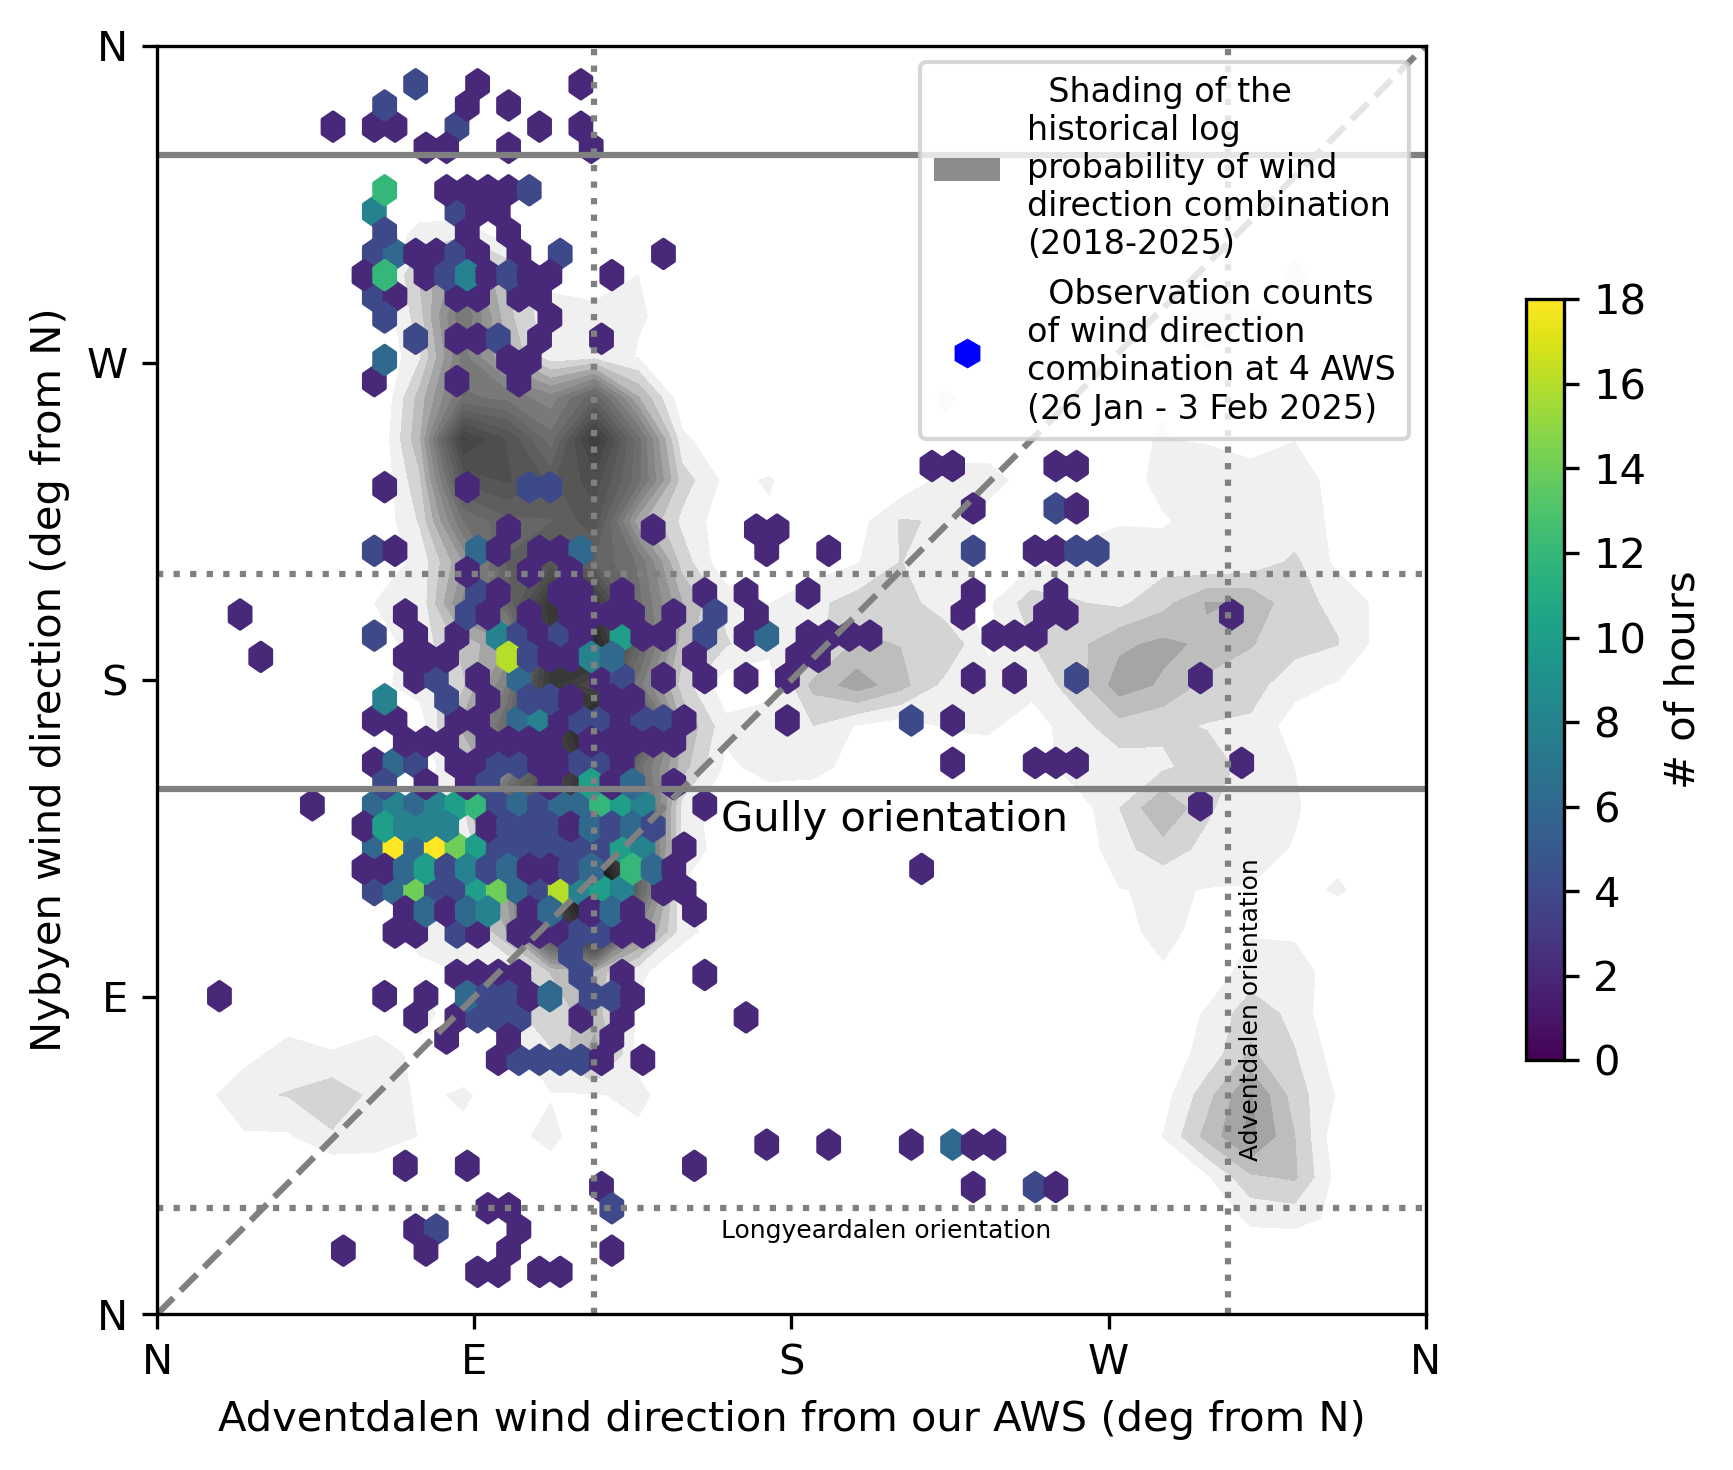

In [32]:
###### For wind speeds > than some value in m/s
#wind_speeds = [2,5,10] # length L : L+1 plots

fig,ax = plt.subplots(figsize=(7,5), dpi=300)

vmax=18 # for scaling purposes
vmin=0
min_ws = 2

condi = adventdalen_nybyen_df.ws_nybyen >= min_ws
x = adventdalen_nybyen_df.loc[condi].wd_adventdalen
y = adventdalen_nybyen_df.loc[condi].wd_nybyen

counts, xedges, yedges = np.histogram2d(x, y, bins=30)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xcenters, ycenters)

# Step 3: Interpolate counts onto a finer grid
xi = np.linspace(x.min(), x.max(), 30)  # Fine grid for contours
yi = np.linspace(y.min(), y.max(), 30)
XI, YI = np.meshgrid(xi, yi)
ZI = griddata((X.ravel(), Y.ravel()), counts.T.ravel(), (XI, YI), method='cubic')

ax.contourf(XI, YI, ZI, levels=30, cmap="Greys", norm='log')
#ax.hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin, cmap='Greys')
#ax.set_title(r'$w_s < %.1f\ m\ s^{-1}$'%wind_speeds[0])

ax.set_aspect('equal')
ax.set_xlim(0,360)
ax.set_ylim(0,360)
ax.axline([0,0], slope=1, c='grey', ls='--')
ax.set_xticks([0,90,180,270,360], labels=['N','E','S','W','N'])
ax.set_yticks([0,90,180,270,360], labels=['N','E','S','W','N'])
    #ax.grid()

ax.set_ylabel('Nybyen wind direction (deg from N)')
ax.set_xlabel('Adventdalen wind direction from our AWS (deg from N)')
#fig.colorbar(pcm, ax=axs, orientation='horizontal', location='top', pad=-.45, shrink=.5, label='counts')

ax.legend([Patch(facecolor='grey', alpha=.9),
           Line2D([0], [0], lw=0, marker='h', color='blue')],
                  ['  Shading of the\nhistorical log\nprobability of wind\ndirection combination\n(2018-2025)', 
                   '  Observation counts\nof wind direction\ncombination at 4 AWS\n(26 Jan - 3 Feb 2025)'], 
          loc='upper right', fontsize=8)

pcm=ax.hexbin(channeling_our_obs_nybyen_adventdalen.wd_AWS, channeling_our_obs_nybyen_adventdalen.wd_nybyen, mincnt=1, vmax=vmax, vmin=vmin, gridsize=50)
fig.colorbar(pcm, shrink=.6, label='# of hours')

ax.axvline(stations['SN99870']['valley_orientation'], ls=':', c='grey')
ax.axvline(stations['SN99870']['valley_orientation']+180, ls=':', c='grey')
ax.text(stations['SN99870']['valley_orientation']+3+180, 45, 'Adventdalen orientation', ha='left', rotation=90, fontsize=6)

ax.axhline(stations['SN99864']['valley_orientation'], ls=':', c='grey')
ax.axhline(stations['SN99864']['valley_orientation']+180, ls=':', c='grey')
ax.text(160, stations['SN99864']['valley_orientation']-3, 'Longyeardalen orientation', fontsize=6, va='top')

ax.axhline(149, ls='-', c='grey')
ax.axhline(149+180, ls='-', c='grey')
ax.text(160, 149-3, 'Gully orientation', va='top')

fig.tight_layout()

plt.savefig('../figs/channeling_nybyen_VS_adventdalen_our_storm_VS_history.png')